In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import emlearn  # Libreria per convertire modelli ML in C

# 📌 Caricare il dataset aggiornato
file_path = "indoor_data.csv"
df = pd.read_csv(file_path)

# 📌 Rinominare le colonne per una migliore leggibilità
df.rename(columns={
    "field1": "MQ7_CO",
    "field2": "MQ135_AirQuality",
    "field3": "Temperature",
    "field4": "Humidity",
    "field5": "eCO2",
    "field6": "TVOC",
    "field7": "DustDensity"
}, inplace=True)

# 📌 Selezionare solo le colonne rilevanti per il training
df = df[['Temperature', 'Humidity', 'DustDensity']].dropna()

# 📌 Creazione delle feature autoregressive utilizzando gli ultimi 10 valori
history_length = 10

for i in range(1, history_length + 1):
    df[f'Temperature_lag_{i}'] = df['Temperature'].shift(i)
    df[f'Humidity_lag_{i}'] = df['Humidity'].shift(i)
    df[f'DustDensity_lag_{i}'] = df['DustDensity'].shift(i)

# 📌 Eliminazione delle righe con valori NaN (dovuti allo shift)
df_ar = df.dropna()

# 📌 Definizione delle feature e del target
X = df_ar[[col for col in df_ar.columns if 'lag' in col]]
y = df_ar['Temperature']

# 📌 Suddivisione dei dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Addestramento del modello di regressione
temperature_model = RandomForestRegressor(n_estimators=100, random_state=42)
temperature_model.fit(X_train, y_train)

# 📌 Predizione sui dati di test
y_pred = temperature_model.predict(X_test)

# 📌 Valutazione del modello
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 📌 Conversione in C con emlearn
model_c_code = emlearn.convert(temperature_model, method='inline')

# 📌 Salvataggio del modello come file C
c_filename = "temperature_prediction_model.h"
with open(c_filename, "w") as f:
    f.write(model_c_code)

print(f"✅ Modello salvato in {c_filename}")

# 📌 Restituzione dei risultati
prediction_results = {
    "MAE Temperature Prediction": mae,
    "R2 Score Temperature Prediction": r2,
}

print(prediction_results)


ModuleNotFoundError: No module named 'pandas'

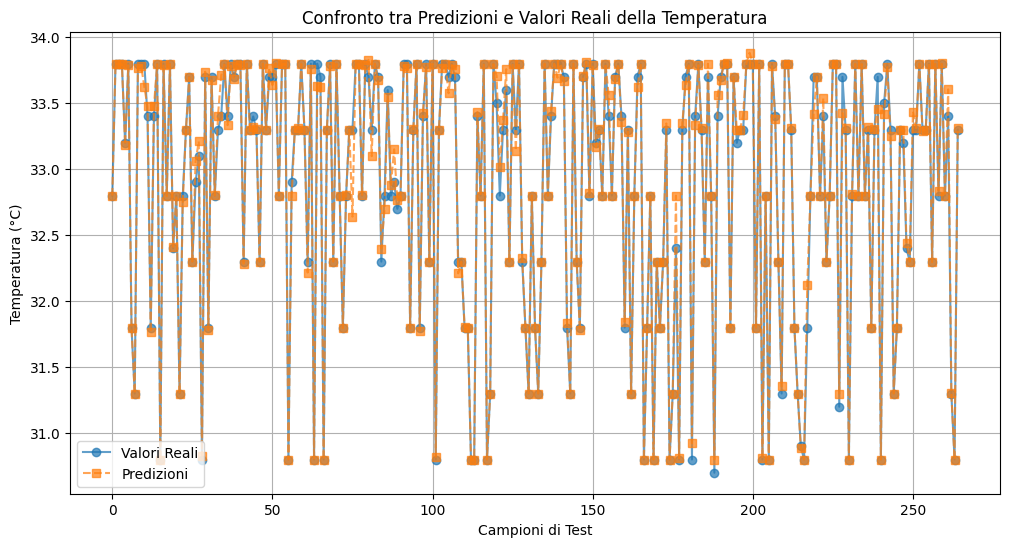

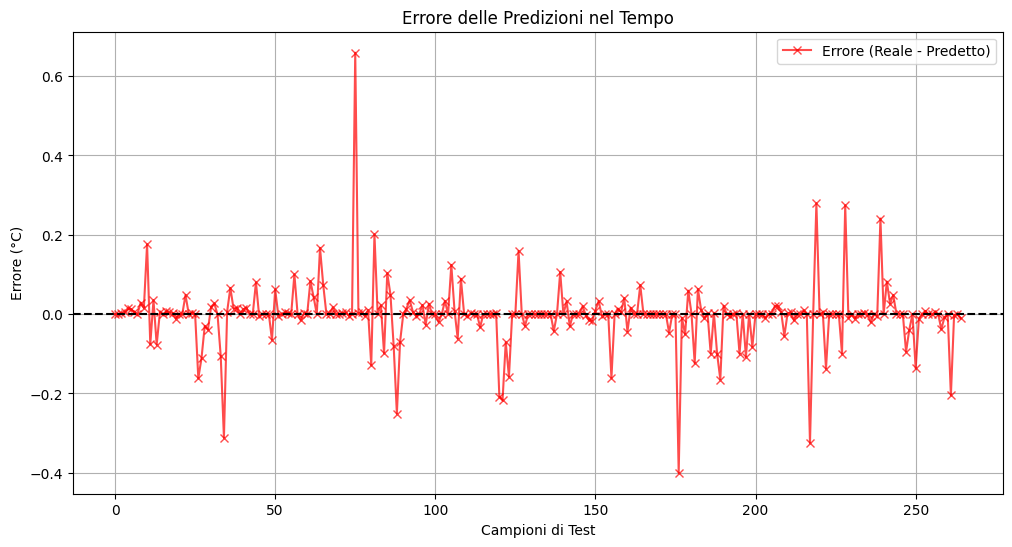

In [8]:
# Creazione di un grafico per confrontare le predizioni con i valori reali nel tempo

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Valori Reali", linestyle="-", marker="o", alpha=0.7)
plt.plot(y_pred, label="Predizioni", linestyle="--", marker="s", alpha=0.7)
plt.xlabel("Campioni di Test")
plt.ylabel("Temperatura (°C)")
plt.title("Confronto tra Predizioni e Valori Reali della Temperatura")
plt.legend()
plt.grid(True)
plt.show()

# Creazione di un grafico per visualizzare gli errori delle predizioni nel tempo

plt.figure(figsize=(12, 6))
plt.plot(y_test.values - y_pred, label="Errore (Reale - Predetto)", linestyle="-", marker="x", alpha=0.7, color='red')
plt.xlabel("Campioni di Test")
plt.ylabel("Errore (°C)")
plt.title("Errore delle Predizioni nel Tempo")
plt.axhline(0, color="black", linestyle="--")  # Linea di riferimento a zero errore
plt.legend()
plt.grid(True)
plt.show()


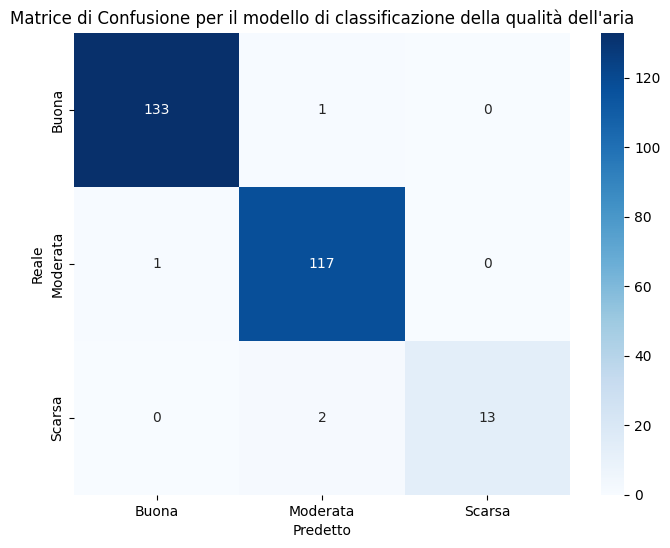

{'Classification Report Air Quality': '              precision    recall  f1-score   support\n\n       Buona       0.99      0.99      0.99       134\n    Moderata       0.97      0.99      0.98       118\n      Scarsa       1.00      0.87      0.93        15\n\n    accuracy                           0.99       267\n   macro avg       0.99      0.95      0.97       267\nweighted avg       0.99      0.99      0.98       267\n'}

In [7]:
# Ricaricare il dataset per recuperare eCO2
df = pd.read_csv(file_path)

# Rinominare le colonne per una migliore leggibilità
df.rename(columns={
    "field1": "MQ7_CO",
    "field2": "MQ135_AirQuality",
    "field3": "Temperature",
    "field4": "Humidity",
    "field5": "eCO2",
    "field6": "TVOC",
    "field7": "DustDensity"
}, inplace=True)

# Selezione delle feature per il modello di classificazione della qualità dell’aria
df = df[['MQ7_CO', 'MQ135_AirQuality', 'TVOC', 'eCO2']].dropna()

# Creazione della colonna Danger_Level basata su eCO2
df['Danger_Level'] = pd.cut(df['eCO2'], bins=[0, 600, 900, float('inf')], labels=[0, 1, 2])

# Definizione delle feature e del target
X_classification = df[['MQ7_CO', 'MQ135_AirQuality', 'TVOC']]
y_classification = df['Danger_Level']

# Suddivisione dei dati in training e test set per la classificazione
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

# Addestramento del modello di classificazione (Random Forest Classifier)
classification_model = RandomForestClassifier(n_estimators=100, random_state=42)
classification_model.fit(X_train_class, y_train_class)

# Predizione dei valori di test
y_pred_class = classification_model.predict(X_test_class)

# Valutazione del modello di classificazione
classification_rep = classification_report(y_test_class, y_pred_class, target_names=['Buona', 'Moderata', 'Scarsa'])
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Salvataggio del modello
joblib.dump(classification_model, "danger_air_classification.h")

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Buona', 'Moderata', 'Scarsa'], yticklabels=['Buona', 'Moderata', 'Scarsa'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione per il modello di classificazione della qualità dell'aria")
plt.show()

# Restituzione dei risultati
classification_results = {
    "Classification Report Air Quality": classification_rep,
}

classification_results
